# Sequence To Sequence Attention Models In PyCNN

One of the most coveted AI tasks is automatic machine translation (MT). In this task a sequence of words in a source language are translated into a sequence of words in a target language (usually those sequences are of different lengths). In order to succeed in this task, the model needs to generalize language patterns from a relatively small dataset of translated examples (the number of possible sentences in each language is large enough to be considered infinite). 

Sequence to sequence neural models have been shown to make such generalizations for input and output of variable lengths. 
For example: [Bahdanau et al.2015] Neural Machine Translation by Jointly Learning to Align and Translate in ICLR 2015
(https://arxiv.org/abs/1409.0473) achieves nearly state of the art results in MT.

In this tutorial, we solve a toy problem on a synthetic dataset to learn the reverse function (map "abcd" to "dcba") using the same models developed to solve MT.

We review three models of increasing sophistication: 
* a simple Recurrent Neural Network (RNN)
* a sequence to sequence encoder-decoder model (https://www.tensorflow.org/versions/r0.9/tutorials/seq2seq/index.html)
* finally, an Attention Based model as introduced by Bahdanau et al.

This is a hands-on description of these models, using the PyCNN framework.
Make sure you first install PyCNN following these instructions: https://github.com/clab/cnn/blob/master/INSTALL.md

The task we address is the following: the input is a random string $(c_0, c_1, c_2 ... c_n)$ of random length n and the output is the reversed string $(c_n, c_{n-1}, c_{n-2} ... c_0)$.

Let's build a function that generates an $(input, output)$ instance of our reverse function:

In [1]:
%matplotlib inline
from random import choice, randrange

EOS = "<EOS>" #all strings will end with the End Of String token
characters = list("abcd")
characters.append(EOS)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-1]) for _ in xrange(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse

Let us generate a couple $(Input, Output)$ examples:

In [2]:
print sample_model(4, 5)
print sample_model(5, 10)

('bcdc', 'cdcb')
('accdbddb', 'bddbdcca')


In order to compare different models under identical conditions, we create a dataset in advance. 
The dataset contains 3,000* random strings with lengths ranging from 1 to 15.<br><br> 

*Note that there are more than $\sum_{n=1}^{14} 4^{n} >> 4^{14} = 268,435,456$ possible random strings so a dataset containing only 3,000 strings means our model will really need to generalize.

In [3]:
MAX_STRING_LEN = 15

train_set = [sample_model(1, MAX_STRING_LEN) for _ in xrange(3000)]
val_set = [sample_model(1, MAX_STRING_LEN) for _ in xrange(50)]

As usual, We split the data set into train and validation subsets. 

We define a $train$ function to optimize a model on our training dataset and plot training errors as learning proceeds over the validation set.  

This method uses generic interface of the PyCNN network class which is used to encode any neural network model:
* network.get_loss(input, output)
* pc.SimpleSGDTrainer(network.model)

This applies a backpropagation training regime over the network for a set number of epochs.

In [4]:
import matplotlib.pyplot as plt
import pycnn as pc

def train(network, train_set, val_set, epochs = 20):
    def get_val_set_loss(network, val_set):
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in val_set]
        return sum(loss)
    
    train_set = train_set*epochs
    trainer = pc.SimpleSGDTrainer(network.model)
    losses = []
    iterations = []
    for i, training_example in enumerate(train_set):
        input_string, output_string = training_example
        
        loss = network.get_loss(input_string, output_string)
        loss_value = loss.value()
        loss.backward()
        trainer.update()

        # Accumulate average losses over training to plot
        if i%(len(train_set)/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    plt.axis([0, 100, 0, len(val_set)*MAX_STRING_LEN])
    plt.show() 
    print 'loss on validation set:', val_loss

## Simple RNN Model

First, let us test our toy problem using a simple Recurrent Neural Network (RNN). 
This model can handle inputs of variable lengths, but it cannot produce outputs of variable lengths. 
Luckily for us, in our problem the length of the input and the output are equal.

Specifically, we will use LSTM units in our RNN - read background information about LSTMs: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Then make sure to read about RNNs in pycnn: https://github.com/clab/cnn/blob/master/pyexamples/tutorials/RNNs.ipynb

If you want, compare it with the Tensorflow corresponding tutorial: https://www.tensorflow.org/versions/r0.9/tutorials/recurrent/index.html

Note that in all of our models, we have character units - that is, we consider sequences of characters.
In many other models, we could consider sequences of words instead of characters, and sometimes sequences of morphemes or word segments.

<img src="img/rnn.jpg" width="50%" height="50%">

We will develop three models that are all refinements of the same structure.
We therefore define a base class that has the following interface:
* A constructor with the hyper-parameters of the network (number of layers, sizes of embeddings and for the latent state of the units.
* Pre-processors for input and output to normalize the sequences coming in and out of the network.  In our case, these simply add the special <EOS> tokens.
* The method $get\_probs(rnn\_output)$ maps the computed output of the RNN to a probability distribution over candidate characters by applying a simple softmax transformation - and the corresponding $predict(probs)$ method which picks the maximum likelihood character given the prob distribution.
* $get\_loss(input\_string, output\_string)$ computes the overall loss of the network on a single pair.  It runs the network over the input, for each input char, it computes the distribution of possible output chars, and then computes the cross-entropy loss for each character: $-\sum_{output\_char} log(prob(output\_char))$.
* $generate(input\_string)$ which generates a candidate output given the input based on the current state of the network.

In [5]:
RNN_BUILDER = pc.LSTMBuilder

class SimpleRNNNetwork:
    def __init__(self, rnn_num_of_layers, embeddings_size, state_size):
        self.model = pc.Model()

        # the embedding paramaters
        self.model.add_lookup_parameters("lookup", (VOCAB_SIZE, embeddings_size))

        # the rnn
        self.RNN = RNN_BUILDER(rnn_num_of_layers, embeddings_size, state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.model.add_parameters("output_w", (VOCAB_SIZE, state_size))
        self.model.add_parameters("output_b", (VOCAB_SIZE))
    
    def _add_eos(self, string):
        string = list(string) + [EOS]
        return [char2int[c] for c in string]
    
    # preprocessing function for all inputs (should be overriden for different problems)
    def _preprocess_input(self, string):
        return self._add_eos(string)
    
    # preprocessing function for all outputs (should be overriden for different problems)
    def _preprocess_output(self, string):
        return self._add_eos(string)
    
    def _embed_string(self, string):
        lookup = self.model["lookup"]
        return [lookup[char] for char in string]

    def _run_rnn(self, init_state, input_vecs):
        s = init_state

        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        return rnn_outputs
    
    def _get_probs(self, rnn_output):
        output_w = pc.parameter(self.model["output_w"])
        output_b = pc.parameter(self.model["output_b"])

        probs = pc.softmax(output_w * rnn_output + output_b)
        return probs

    def get_loss(self, input_string, output_string):
        input_string = self._preprocess_input(input_string)
        output_string = self._preprocess_output(output_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        rnn_state = self.RNN.initial_state()
        rnn_outputs = self._run_rnn(rnn_state, embedded_string)
        loss = []
        for rnn_output, output_char in zip(rnn_outputs, output_string):
            probs = self._get_probs(rnn_output)
            loss.append(-pc.log(pc.pick(probs, output_char)))
        loss = pc.esum(loss)
        return loss

    def _predict(self, probs):
        probs = probs.value()
        predicted_char = int2char[probs.index(max(probs))]
        return predicted_char
    
    def generate(self, input_string):
        input_string = self._preprocess_input(input_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        rnn_state = self.RNN.initial_state()
        rnn_outputs = self._run_rnn(rnn_state, embedded_string)
        
        output_string = []
        for rnn_output in rnn_outputs:
            probs = self._get_probs(rnn_output)
            predicted_char = self._predict(probs)
            output_string.append(predicted_char)
        output_string = ''.join(output_string)
        return output_string

We are now ready to run the first RNN network over our sample dataset - and test it on a simple "ab" string:

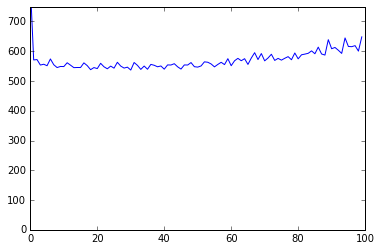

loss on validation set: 648.308116913
ab<EOS>


In [6]:
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = 4
STATE_SIZE = 128


rnn = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(rnn, train_set, val_set)
print rnn.generate('ab')

We observe that the loss does not improve over time - training does not converge.
We also see that the network did not learn how to reverse 'ab'.

Our RNN model has no chance to learn the $reverse\ function$ since it predicts each output character $o_i$ immediately after reading input character $i_i$. So when predicting the 1st output charcter the RNN didn't even see the last input charcter.

No magic going on here - so let's improve.


## Encoder Decoder Model

We will now try to solve our problem using the encoder-decoder model. An encoder RNN will read the entire input string and generate a fixed length encoded vector to represent the entire input string. The decoder RNN will then use the encoded string to predict the output.

This strategy should address the concern we identified above - which is that to generate a reverse string properly we should first look at the whole input string - then start generating. 

Naturally, we are still skeptical: can it be that the encoder will "remember" the input string sufficiently to generate the whole output strings?  Let us try it.

<img src="img/encdec.jpg" width="50%" height="50%">

We prepare a new class EncoderDecoderNetwork which derives from SimpleRNNNetwork.

In the constructor, we build two RNNs - encoder and decoder.
We define a new method $encode\_string(embedded\_string)$ which runs the input string into the encoder.
We then adapt $generate(input\_string)$ and $get_loss(input\_string, output\_string)$ to perform the 
encoder / decoder choreography.

Note that the decoder receives the same encoding of the whole input string for all slices.
Each slice of the decoder must learn to decide what "part" of the encoding it should look at to decide
which output to produce - based on the latent state the previous slice produced (remember that all slices are
repetitions of the same network unit with the same parameters).

In [7]:
class EncoderDecoderNetwork(SimpleRNNNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        self.model = pc.Model()

        # the embedding paramaters
        self.model.add_lookup_parameters("lookup", (VOCAB_SIZE, embeddings_size))

        # the rnns
        self.ENC_RNN = RNN_BUILDER(enc_layers, embeddings_size, enc_state_size, self.model)
        self.DEC_RNN = RNN_BUILDER(dec_layers, enc_state_size, dec_state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.model.add_parameters("output_w", (VOCAB_SIZE, dec_state_size))
        self.model.add_parameters("output_b", (VOCAB_SIZE))

    def _encode_string(self, embedded_string):
        initial_state = self.ENC_RNN.initial_state()

        # run_rnn returns all the hidden state of all the slices of the RNN
        hidden_states = self._run_rnn(initial_state, embedded_string)

        return hidden_states

    def get_loss(self, input_string, output_string):
        input_string = self._add_eos(input_string)
        output_string = self._add_eos(output_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        # The encoded string is the hidden state of the last slice of the encoder
        encoded_string = self._encode_string(embedded_string)[-1]

        rnn_state = self.DEC_RNN.initial_state()

        loss = []
        for output_char in output_string:
            rnn_state = rnn_state.add_input(encoded_string)
            probs = self._get_probs(rnn_state.output())
            loss.append(-pc.log(pc.pick(probs, output_char)))
        loss = pc.esum(loss)
        return loss


    def generate(self, input_string):
        input_string = self._add_eos(input_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)[-1]

        rnn_state = self.DEC_RNN.initial_state()

        output_string = []
        while True:
            rnn_state = rnn_state.add_input(encoded_string)
            probs = self._get_probs(rnn_state.output())
            predicted_char = self._predict(probs)
            output_string.append(predicted_char)
            if predicted_char == EOS or len(output_string) > 2*len(input_string):
                break
        output_string = ''.join(output_string)
        return output_string.replace('<EOS>', '')

We are now ready to run it:

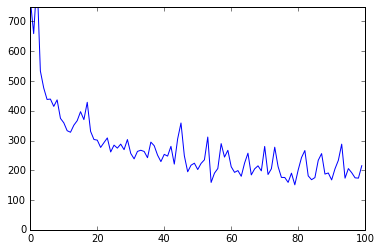

loss on validation set: 215.403840679
dcba
dcbadabddddccaa


In [8]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 64
DEC_STATE_SIZE = 64

encoder_decoder = EncoderDecoderNetwork(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(encoder_decoder, train_set, val_set)
print encoder_decoder.generate('abcd')
print encoder_decoder.generate('abcdabcdabcdabcd')

The loss curve indicates this model is doing much better than the hepless SimpleRNN.  It is "learning" something.
But it hits a plateau and remains unstable after the 10th iteration.

Since the encoder decoder uses a fixed length vector to represent variable size input strings it can't properly represent long input strings. 

Lets test it:

In [9]:
short_strings = [sample_model(1, 5) for _ in xrange(100)]
medium_strings = [sample_model(5, 10) for _ in xrange(100)]
long_strings = [sample_model(10, 15) for _ in xrange(100)]

def count_matches(network, val_set):
    matches = [network.generate(input_string)==output_string for input_string, output_string in val_set]
    return matches.count(True)

print 'Matches for short strings', count_matches(encoder_decoder, short_strings)
print 'Matches for medium strings', count_matches(encoder_decoder, medium_strings)
print 'Matches for long strings', count_matches(encoder_decoder, long_strings)

Matches for short strings 100
Matches for medium strings 73
Matches for long strings 7


Overall, the encoder-decoder model does improve over the Simple RNN but hits a plateau because it has limited memory.

## Attention Model

The *attention model* was introduced to address the limitation we just observed:
* How does the decoder know which part of the encoding is relevant at each step of the generation.
* How can we overcome the limited memory of the encoder so that we can "remember" more of the encoding process than a single fixed size vector.

The attention model comes between the encoder and the decoder and helps the decoder to pick only the encoded inputs that are important for each step of the decoding process.  

<img src="img/att.jpg" width="50%" height="50%">

For each encoded input from the encoder RNN, the attention mechanism calculates its importance:

$importance_{ij} =V*tanh(encodedInput_iW_1+decoderstate_jW_2)$<br>
$importance_{ij}$ is the importance of encoded vector $i$ at decoding step $j$<br>
$W_1$, $W_2$ and $V$ are learned parameters <br>

Once we calculate the importance of each encoded vector, we normalize the vectors with softmax and multiply each encoded vector by its weight to obtain a "time dependent" input encoding which is fed to each step of the decoder RNN.

Note that in this model, the attention mechanism computes a fixed-size vector that encodes the whole input sequence based on the sequence of *all* the outputs generated by the encoder (as opposed to the encoder-decoder model above which was looking ONLY at the last state generated by the encoder for all the slices of the decoder).

We prepare a new class that refines the EncoderDecoderNetwork.  AttentionNetwork adds the units of the attention model ($W_1, W_2 and V$) in its constructor. 

The method $attend(input_vectors, state)$ computes the weighted representation of the whole input string for each slide of the decoder.

$get_loss(input\_string, output\_string)$ and $generate(input\_string)$ are adapted to introduce the call to $attend()$ in the overall choreography.

In [10]:
class AttentionNetwork(EncoderDecoderNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        EncoderDecoderNetwork.__init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size)

        # attention weights
        self.model.add_parameters("attention_w1", (enc_state_size, enc_state_size))
        self.model.add_parameters("attention_w2", (enc_state_size, dec_state_size))
        self.model.add_parameters("attention_v", (1, enc_state_size))

        self.enc_state_size = enc_state_size

    def _attend(self, input_vectors, state):
        w1 = pc.parameter(self.model['attention_w1'])
        w2 = pc.parameter(self.model['attention_w2'])
        v = pc.parameter(self.model['attention_v'])
        attention_weights = []

        w2dt = w2 * state.h()[-1]
        for input_vector in input_vectors:
            attention_weight = v * pc.tanh(w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        attention_weights = pc.softmax(pc.concatenate(attention_weights))

        output_vectors = pc.esum(
            [vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
        return output_vectors

    def get_loss(self, input_string, output_string):
        input_string = self._add_eos(input_string)
        output_string = self._add_eos(output_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)

        rnn_state = self.DEC_RNN.initial_state().add_input(pc.vecInput(self.enc_state_size))

        loss = []
        for output_char in output_string:
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            probs = self._get_probs(rnn_state.output())
            loss.append(-pc.log(pc.pick(probs, output_char)))
        loss = pc.esum(loss)
        return loss

    def generate(self, input_string):
        input_string = self._add_eos(input_string)

        pc.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)

        rnn_state = self.DEC_RNN.initial_state().add_input(pc.vecInput(self.enc_state_size))

        output_string = []
        while True:
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            probs = self._get_probs(rnn_state.output())
            predicted_char = self._predict(probs)
            output_string.append(predicted_char)
            if predicted_char == EOS or len(output_string) > 2*len(input_string):
                break
        output_string = ''.join(output_string)
        return output_string.replace('<EOS>', '')

Ready to try it:

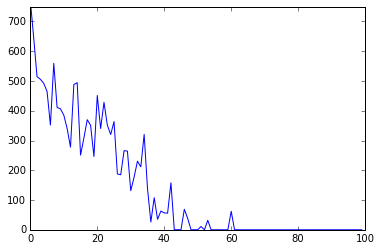

loss on validation set: 0.0921042754053
dcbadcbadcbadcba


In [11]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

att = AttentionNetwork(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(att, train_set, val_set)
print att.generate('abcdabcdabcdabcd')

It seems like the attention mechanism solved our problem! 

In [12]:
print 'Matches for short strings', count_matches(att, short_strings)
print 'Matches for medium strings', count_matches(att, medium_strings)
print 'Matches for long strings', count_matches(att, long_strings) 

Matches for short strings 100
Matches for medium strings 100
Matches for long strings 100


Loss went down on the same dataset from 200 to 0.  We now can predict correctly long strings.

How did this happen?  Let us zoom in on the attention part of the model and try to illustrate what was learned.

## Attention Weights

Let's make a version of the attention network that plots the attention of each encoded input at each decoding step when generating.  We want to look at what was the relative weight that was computed for each of the outputs of the encoders 
$encOutput_i$ when generating each of the output characters $Output_j$

This has the shape of a matrix NxN which will tell us where the model is "focusing" on the input encodings when it decides to generate each output char.

In [13]:
import numpy as np

class AttentionNetworkWithPrint(AttentionNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        AttentionNetwork.__init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size)

        self.should_print = False
        self.att_mat = []

    def _attend(self, input_vectors, state):
        w1 = pc.parameter(self.model['attention_w1'])
        w2 = pc.parameter(self.model['attention_w2'])
        v = pc.parameter(self.model['attention_v'])
        attention_weights = []

        w2dt = w2 * state.h()[-1]
        for input_vector in input_vectors:
            attention_weight = v * pc.tanh(w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        attention_weights = pc.softmax(pc.concatenate(attention_weights))
        if self.should_print:
            self.att_mat.append(attention_weights.value())
        output_vectors = pc.esum(
            [vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
        return output_vectors

    def _plot_attention(self, matrix, max_weight=None, ax=None):
        """Draw Hinton diagram for visualizing a weight matrix."""
        ax = ax if ax is not None else plt.gca()

        if not max_weight:
            max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

        ax.patch.set_facecolor('gray')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        for (x, y), w in np.ndenumerate(matrix):
            color = 'white' if w > 0 else 'black'
            size = np.sqrt(np.abs(w))
            rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
            ax.add_patch(rect)

        ax.autoscale_view()
        ax.invert_yaxis()
        plt.show()
    
    def generate_and_plot_attention(self, input_string):
        att.should_print = True
        att.att_mat = []
        output_string = self.generate(input_string)
        self._plot_attention(np.array(att.att_mat))
        att.should_print = False
        att.att_mat = []
        return output_string

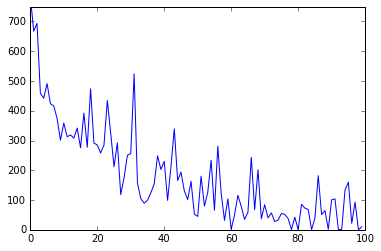

loss on validation set: 10.2821848333


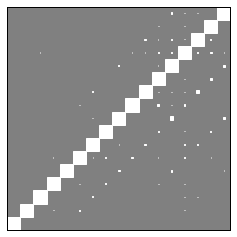

dcbadcbadcbadcba


In [14]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

att = AttentionNetworkWithPrint(ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(att, train_set, val_set)

att.att_mat = []
print att.generate_and_plot_attention('abcdabcdabcdabcd')

When plotting the attention weights of each input stage we can see that for we get a diagonal line. When generation stage $i$ the most important input was $|input|-i$

In other words, the attention model learned pretty well the structure of the "reverse" function on our test sample by looking at 3,000 sample strings.

We recommend to read the following book for an extended introduction to NLP using neural networks: http://www.kyunghyuncho.me/home/blog/lecturenotefornlpwithdistributedreponarxivnow

About me: https://www.cs.bgu.ac.il/~talbau/